In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline 

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1.0 Data Preprocessing

In [2]:
# I did this on IBM cloud where file size limit was 256 MB. Hence I removed duplicates.
# Also, the score has been turned into binary class- Positive and Negative

con = sqlite3.connect(r"final.sqlite")
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)
filtered_data.shape

(364171, 11)

In [3]:
# Taking first 100,000 points for analysis

filtered_data = filtered_data.sort_values(by=['Time'])
final = filtered_data[:100000]
final.Score.value_counts()

Positive    87729
Negative    12271
Name: Score, dtype: int64

In [4]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        #print(i)
        #print(sent)
        break;
    i += 1;    

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

stop = set(stopwords.words('english')) #set of stopwords
sno = SnowballStemmer('english') #initialising the snowball stemmer

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kushalkul01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [6]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [7]:
final = final.sort_values(by=['Time']) #Just to be double sure that dataframe is sorted according to time

# Taking labels to make y-dimension
labels=final['Score'].values

# Checking the shape of labels
print("Shape of y-vector is",labels.shape)

Shape of y-vector is (100000,)


In [8]:
# Taking initial 70% data as training data and remaining 30% as test data

l = 0.7 * final.shape[0]
X_train = final['CleanedText'][0:int(l)]
X_test = final['CleanedText'][int(l):]
y_train = labels[0:int(l)]
y_test = labels[int(l):]

# 2.0 Bag-of-Words Model

In [9]:
# Making the bag of words model
# Fitting the model on Training data and transforming the test data on the fitted model
# This helps in taking care of data leakage

from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)
y_train_bow = y_train
y_test_bow = y_test
print("The type of count vectorizer ",type(X_train_bow))

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


In [12]:
# Normalizing the data

from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=False)
X_train_bow = ss.fit_transform(X_train_bow)
X_test_bow = ss.transform(X_test_bow)

In [13]:
# Converting 'Positive' and 'Negative' into True and False

y_train_bow = y_train_bow=='Positive'
y_test_bow = y_test_bow=='Positive'

### 2.1 Grid Seach CV

#### 2.1.1 Using L1 Regularization

In [12]:
# Finding the best parameters using Grid Seach CV using 10-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4, 10**-2, 1, 10**2, 10**4]}]
gridmodel1 = GridSearchCV(LogisticRegression(penalty = 'l1'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
gridmodel1.fit(X_train_bow, y_train_bow)

print(gridmodel1.best_estimator_)
print("Optimal F-score: {:.2f}".format(gridmodel1.score(X_test_bow, y_test_bow)))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Optimal F-score: 0.95


#### 2.1.2 Using L2 Regularizer

In [13]:
# Finding the best parameters using Grid Seach CV using 10-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4, 10**-2, 1, 10**2, 10**4]}]
gridmodel2 = GridSearchCV(LogisticRegression(penalty = 'l2'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
gridmodel2.fit(X_train_bow, y_train_bow)

print(gridmodel2.best_estimator_)
print("Optimal F-score: {:.2f}".format(gridmodel2.score(X_test_bow, y_test_bow)))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Optimal F-score: 0.95


### 2.2 Randomized Search CV

#### 2.2.1 Using L1 Regularization

In [15]:
# Finding the best parameters using Random Seach CV

from sklearn.model_selection import RandomizedSearchCV
random_parameters = {'C': [10**-4,10**-3,10**-2,10**-1, 1, 10, 100, 1000]}
randommodel1 = RandomizedSearchCV(LogisticRegression(penalty='l1'), random_parameters, scoring = 'f1', cv=2, n_iter=4, n_jobs=-1)
randommodel1.fit(X_train_bow, y_train_bow)

print(randommodel1.best_estimator_)
print("Optimal F-score: {:.2f}".format(randommodel1.score(X_test_bow, y_test_bow)))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Optimal F-score: 0.93


#### 2.2.2 Using L2 Regularization

In [16]:
# Finding the best parameters using Random Seach CV

from sklearn.model_selection import RandomizedSearchCV
random_parameters = {'C': [10**-5,10**-4,10**-3,10**-2,10**-1, 1, 10, 100, 1000]}
randommodel2 = RandomizedSearchCV(LogisticRegression(penalty='l2'), random_parameters, scoring = 'f1', cv=2, n_iter=4, n_jobs=-1)
randommodel2.fit(X_train_bow, y_train_bow)

print(randommodel2.best_estimator_)
print("Optimal F-score: {:.2f}".format(randommodel2.score(X_test_bow, y_test_bow)))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Optimal F-score: 0.94


Hence out of all the techniques applied, best F-Score (0.95) was obtained. However, both models- Grid and Random gave exactly same results for L1 and L2 regularizer respectively.

### 2.3 Fitting the best model and calculating different performance metrics

Confusion Matrix:


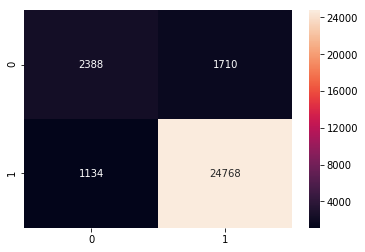

TPR for the model on test data is 0.96
FPR for the model on test data is 0.42
TNR for the model on test data is 0.58
FNR for the model on test data is 0.04



In [17]:
# Fitting the best model

lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(X_train_bow, y_train_bow)
y_pred_bow = lr.predict(X_test_bow)

cm_bow=confusion_matrix(y_test_bow,y_pred_bow)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_bow.ravel()

tnr_bow = tn/(tn+fp)
fpr_bow = fp/(tn+fp)
fnr_bow = fn/(fn+tp)
tpr_bow = tp/(fn+tp)

print("TPR for the model on test data is {:.2f}".format(tpr_bow))
print("FPR for the model on test data is {:.2f}".format(fpr_bow))
print("TNR for the model on test data is {:.2f}".format(tnr_bow))
print("FNR for the model on test data is {:.2f}\n".format(fnr_bow))

In [18]:
# calculating precision and recall 
accuracy_bow = accuracy_score(y_test_bow , y_pred_bow)
precision_bow = precision_score(y_test_bow , y_pred_bow)
recall_bow = recall_score(y_test_bow , y_pred_bow)
f1_bow = f1_score(y_test_bow , y_pred_bow)

print("Accuracy score for the model on test data is {:.2f}".format(accuracy_bow))
print("Precision score for the model on test data is {:.2f}".format(precision_bow))
print("Recall score for the model on test data is {:.2f}".format(recall_bow))
print("F1 score for the model on test data is {:.2f}\n".format(f1_bow))

Accuracy score for the model on test data is 0.91
Precision score for the model on test data is 0.94
Recall score for the model on test data is 0.96
F1 score for the model on test data is 0.95



### 2.4 Checking sparsity with increasing value of lambda (decreasing C)

In [14]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(X_train_bow, y_train_bow)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=23471
lambda=0.001 ; non-zeros=23732
lambda=0.01 ; non-zeros=18284
lambda=0.1 ; non-zeros=14487
lambda=1.0 ; non-zeros=12288
lambda=10.0 ; non-zeros=9669
lambda=100.0 ; non-zeros=3145
lambda=1000.0 ; non-zeros=55
lambda=10000.0 ; non-zeros=0


As it is clear, when the value of λ increases, the number of non-zeros decrease. This implies that when alpha goes up, the number of non-zeros go down and hence number of zeros go up.

As λ reaches ten-thousand, all the values of coefficients approach zero.

### 2.5 Checking for Multicollinearity

In [15]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(X_train_bow, y_train_bow)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
X_train_bow.data = X_train_bow.data + noise[0]

Noise= -0.1282136085523735


In [17]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(X_train_bow, y_train_bow)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(X_train_bow.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 2790


Hence for most of the some features, the value of coefficients changed a lot. Hence features are multicollinear in nature.

In [20]:
# Taking values for probabilities for BoW

lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(X_train_bow, y_train_bow)
prob_score = lr.coef_
probs = prob_score.argsort() # Probabilities of y=1 in ascending order

# Taking words with Maximum Probabilities for negative and positive labels

neg_words = np.take(bow.get_feature_names(), probs[0][:10]) # Lowest probabilities of y=1
pos_words = np.take(bow.get_feature_names(), probs[0][-10:]) # highest probabilities of y=1

print("Negative Words are:\n" , neg_words, end='\n\n')
print("Positive Words are:\n" , pos_words)

Negative Words are:
 ['worst' 'disappoint' 'www' 'tast' 'aw' 'canida' 'context' 'unfortun'
 'earth' 'terribl']

Positive Words are:
 ['favorit' 'amaz' 'nice' 'addict' 'delici' 'good' 'perfect' 'love' 'best'
 'great']


Hence, the positive and negative words are clearly demarcated from the logistic regression

# 3.0 TF-IDF Vectors

In [10]:
# importing the right libraries

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


# making tf-idf vector

tf_idf_vect = TfidfVectorizer() # using ngram_range as (1,1) due to computation restrictions
X_train_tf = tf_idf_vect.fit_transform(X_train)
X_test_tf = tf_idf_vect.transform(X_test)
y_train_tf = y_train
y_test_tf = y_test

In [10]:
# Converting 'Positive' and 'Negative' into True and False

y_train_tf = y_train_tf == 'Positive'
y_test_tf = y_test_tf == 'Positive'

### 3.1 Grid Seach CV for Optimal λ (C) and Penalty (among L1 and L2)

In [12]:
# Finding the best parameters using Random Seach CV

from sklearn.model_selection import GridSearchCV

tuned_parameters = {'C': [10**-4, 10**-2, 1, 10**2, 10**4]}
                   
gridmodel1 = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'f1', cv=2)
gridmodel1.fit(X_train_tf, y_train_tf)

gridmodel2 = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'f1', cv=2)
gridmodel2.fit(X_train_tf, y_train_tf)

print("************************************************************************")
print("\nUsing L1 regularization-\n")
print(gridmodel1.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(gridmodel1.score(X_test_tf, y_test_tf)))
print('\n')
print("************************************************************************")
print('\n')
print("Using L2 regularization- ")
print(gridmodel2.best_estimator_)
print("Optimal F-score: {:.2f}".format(gridmodel2.score(X_test_tf, y_test_tf)))
print('\n')
print("************************************************************************")

************************************************************************

Using L1 regularization-

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.96


************************************************************************


Using L2 regularization- 
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Optimal F-score: 0.95


************************************************************************


### 3.2 Random Seach CV for Optimal λ (C) and Penalty (among L1 and L2)

In [14]:
# Finding the best parameters using Random Seach CV

from sklearn.model_selection import RandomizedSearchCV

random_parameters = {'C': [10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3 , 10**4]}
                   
randommodel1 = RandomizedSearchCV(LogisticRegression(penalty='l1'), random_parameters, scoring = 'f1', cv=2, n_iter=4)
randommodel1.fit(X_train_tf, y_train_tf)

randommodel2 = RandomizedSearchCV(LogisticRegression(penalty='l2'), random_parameters, scoring = 'f1', cv=2, n_iter=4)
randommodel2.fit(X_train_tf, y_train_tf)

print("************************************************************************")
print("\nUsing L1 regularization-\n")
print(randommodel1.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(randommodel1.score(X_test_tf, y_test_tf)))
print('\n')
print("************************************************************************")
print('\n')
print("Using L2 regularization- ")
print(randommodel2.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(randommodel2.score(X_test_tf, y_test_tf)))
print('\n')
print("************************************************************************")

************************************************************************

Using L1 regularization-

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.96


************************************************************************


Using L2 regularization- 
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.96


************************************************************************


Almost similar results for L1 and exactly same for L2.
So, to get best model (highest F1 score), we will use L2 regularization with C=1

### 3.3 Fitting the best model and calculating different performance metrics

Confusion Matrix:


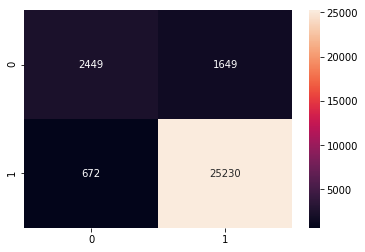

TPR for the model on test data is 0.97
FPR for the model on test data is 0.40
TNR for the model on test data is 0.60
FNR for the model on test data is 0.03



In [15]:
# Fitting the best model

lr = LogisticRegression(penalty='l2', C=10)
lr.fit(X_train_tf, y_train_tf)
y_pred_tf = lr.predict(X_test_tf)

# Generating the confusion matrix
cm_tf = confusion_matrix(y_test_tf , y_pred_tf)
print("Confusion Matrix:")
sns.heatmap(cm_tf, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_tf.ravel()

tnr_tf = tn/(tn+fp)
fpr_tf = fp/(tn+fp)
fnr_tf = fn/(fn+tp)
tpr_tf = tp/(fn+tp)

print("TPR for the model on test data is {:.2f}".format(tpr_tf))
print("FPR for the model on test data is {:.2f}".format(fpr_tf))
print("TNR for the model on test data is {:.2f}".format(tnr_tf))
print("FNR for the model on test data is {:.2f}\n".format(fnr_tf))

In [16]:
# calculating accuracy, precision and recall 

accuracy_tf = accuracy_score(y_test_tf , y_pred_tf)
precision_tf = precision_score(y_test_tf , y_pred_tf)
recall_tf = recall_score(y_test_tf , y_pred_tf)
f1_tf = f1_score(y_test_tf , y_pred_tf)

print("Accuracy score for the model on test data is {:.2f}".format(accuracy_tf))
print("Precision score for the model on test data is {:.2f}".format(precision_tf))
print("Recall score for the model on test data is {:.2f}".format(recall_tf))
print("F1 score for the model on test data is {:.2f}\n".format(f1_tf))

Accuracy score for the model on test data is 0.92
Precision score for the model on test data is 0.94
Recall score for the model on test data is 0.97
F1 score for the model on test data is 0.96



### 3.4 Checking sparsity with increasing value of  λ (decreasing C)

In [17]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(X_train_tf, y_train_tf)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=14552
lambda=0.001 ; non-zeros=13174
lambda=0.01 ; non-zeros=11208
lambda=0.1 ; non-zeros=6811
lambda=1.0 ; non-zeros=1268
lambda=10.0 ; non-zeros=185
lambda=100.0 ; non-zeros=3
lambda=1000.0 ; non-zeros=0
lambda=10000.0 ; non-zeros=0


As it is clear, when the value of λ increases, the number of non-zeros decrease. This implies that when alpha goes up, the number of non-zeros go down and hence number of zeros go up.

As λ reaches 1000, all the values of coefficients approach zero.

### 3.5 Checking for Multicollinearity

In [18]:
# Applying perturbation and checking if the coefficients differ too much

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
X_train_tf.data = X_train_tf.data + noise[0]

Noise= -0.15880593569504242


In [19]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=1)
lr2.fit(X_train_tf, y_train_tf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# Calculating the percentage change between the old and new coefficients

# Calculating the percentage change between the old and new coefficients
count=0
for i in range(X_train_tf.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 28767


The percentage change in the values of coefficients is quite small, hence we can conclude that features are quite independent of each other.

In [22]:
# Taking values for probabilities for BoW

prob_score = lr.coef_
probs = prob_score.argsort()

# Taking words with Maximum Probabilities for negative and positive labels
neg_words = np.take(tf_idf_vect.get_feature_names(), probs[0][:10])
pos_words = np.take(tf_idf_vect.get_feature_names(), probs[0][-10:])

print("Negative Words are:\n" , neg_words, end='\n\n')
print("Positive Words are:\n" , pos_words)

Negative Words are:
 ['worst' 'disappoint' 'terribl' 'aw' 'bland' 'threw' 'horribl' 'unfortun'
 'tasteless' 'ugh']

Positive Words are:
 ['nice' 'awesom' 'addict' 'amaz' 'excel' 'love' 'delici' 'perfect' 'best'
 'great']


# 4.0 Word2Vec

In [11]:
import gensim
from gensim.models import Word2Vec

In [12]:
i=0
list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())

In [13]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
count_vect_feat = bow.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


## 4.1 Average Word2Vec

In [14]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [15]:
list_of_sent_tst=[]
for sent in X_test:
    list_of_sent_tst.append(sent.split())
    
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_tst: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [16]:
X_train_avg = sent_vectors
X_test_avg = sent_vectors_test
y_train_avg = y_train
y_test_avg = y_test

print("Length of X_train :",len(X_train_avg))
print("Length of X_test :",len(X_test_avg))

Length of X_train : 70000
Length of X_test : 30000


In [17]:
# Converting 'Positive' and 'Negative' into True and False

y_train_avg = y_train_avg == 'Positive'
y_test_avg = y_test_avg == 'Positive'

### 4.1.1 Grid Seach CV for Optimal λ (C) and Penalty (among L1 and L2)

In [19]:
# Finding the best parameters using Random Seach CV

from sklearn.model_selection import GridSearchCV

tuned_parameters = {'C': [10**-4, 10**-2, 1, 10**2, 10**4]}
                   
gridmodel1 = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'f1', cv=2)
gridmodel1.fit(X_train_avg, y_train_avg)

gridmodel2 = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'f1', cv=2)
gridmodel2.fit(X_train_avg, y_train_avg)

print("************************************************************************")
print("\nUsing L1 regularization-\n")
print(gridmodel1.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(gridmodel1.score(X_test_avg, y_test_avg)))
print('\n')
print("************************************************************************")
print('\n')
print("Using L2 regularization-\n")
print(gridmodel2.best_estimator_)
print("Optimal F-score: {:.2f}".format(gridmodel2.score(X_test_avg, y_test_avg)))
print('\n')
print("************************************************************************")

************************************************************************

Using L1 regularization-

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.94


************************************************************************


Using L2 regularization-

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Optimal F-score: 0.94


************************************************************************


### 4.1.2 Random Seach CV for Optimal λ (C) and Penalty (among L1 and L2)

In [20]:
# Finding the best parameters using Random Seach CV

from sklearn.model_selection import RandomizedSearchCV

random_parameters = {'C': [10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3 , 10**4]}
                   
randommodel1 = RandomizedSearchCV(LogisticRegression(penalty='l1'), random_parameters, scoring = 'f1', cv=2, n_iter=4)
randommodel1.fit(X_train_avg, y_train_avg)

randommodel2 = RandomizedSearchCV(LogisticRegression(penalty='l2'), random_parameters, scoring = 'f1', cv=2, n_iter=4)
randommodel2.fit(X_train_avg, y_train_avg)

print("************************************************************************")
print("\nUsing L1 regularization-\n")
print(randommodel1.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(randommodel1.score(X_test_avg, y_test_avg)))
print('\n')
print("************************************************************************")
print('\n')
print("Using L2 regularization- ")
print(randommodel2.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(randommodel2.score(X_test_avg, y_test_avg)))
print('\n')
print("************************************************************************")

************************************************************************

Using L1 regularization-

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.94


************************************************************************


Using L2 regularization- 
LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.94


************************************************************************


Hence we got almost similar results for L1 and exactly same for L2.
C=10000 and C=1000 give almost similar result for L2 regularization
So, to get best model (highest F1 score), we will use L1 regularization with C=10000

### 4.1.3 Fitting the best model and calculating different performance metrics

Confusion Matrix:


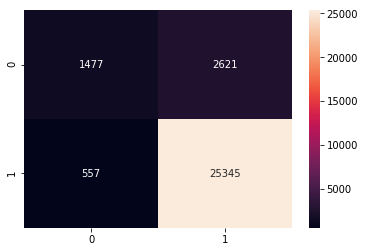

TPR for the model on test data is 0.98
FPR for the model on test data is 0.64
TNR for the model on test data is 0.36
FNR for the model on test data is 0.02



In [21]:
# Fitting the best model

lr = LogisticRegression(penalty='l2', C=1)
lr.fit(X_train_avg, y_train_avg)
y_pred_avg = lr.predict(X_test_avg)

cm_avg = confusion_matrix(y_test_avg , y_pred_avg)
print("Confusion Matrix:")
sns.heatmap(cm_avg, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_avg.ravel()

tnr_avg = tn/(tn+fp)
fpr_avg = fp/(tn+fp)
fnr_avg = fn/(fn+tp)
tpr_avg = tp/(fn+tp)

print("TPR for the model on test data is {:.2f}".format(tpr_avg))
print("FPR for the model on test data is {:.2f}".format(fpr_avg))
print("TNR for the model on test data is {:.2f}".format(tnr_avg))
print("FNR for the model on test data is {:.2f}\n".format(fnr_avg))

In [22]:
# calculating accuracy, precision and recall 

accuracy_avg = accuracy_score(y_test_avg , y_pred_avg)
precision_avg = precision_score(y_test_avg , y_pred_avg)
recall_avg = recall_score(y_test_avg , y_pred_avg)
f1_avg = f1_score(y_test_avg , y_pred_avg)

print("Accuracy score for the model on test data is {:.2f}".format(accuracy_avg))
print("Precision score for the model on test data is {:.2f}".format(precision_avg))
print("Recall score for the model on test data is {:.2f}".format(recall_avg))
print("F1 score for the model on test data is {:.2f}\n".format(f1_avg))

Accuracy score for the model on test data is 0.89
Precision score for the model on test data is 0.91
Recall score for the model on test data is 0.98
F1 score for the model on test data is 0.94



### 4.1.4 Checking sparsity with increasing value of  λ (decreasing C)

In [23]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(X_train_avg, y_train_avg)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=48
lambda=10.0 ; non-zeros=48
lambda=100.0 ; non-zeros=30
lambda=1000.0 ; non-zeros=8
lambda=10000.0 ; non-zeros=0


We can't check for multicollinearity for this vectorization technique as we don't have a single feature corresponding to a particular word. What we can do is just to extract most important features in the form of list.

In [21]:
# Taking values for probabilities for Average-W2V

prob_score = lr.coef_

probs = prob_score.argsort()

# Taking words with Maximum Probabilities for negative and positive labels
neg_words = np.take(sent_vectors, probs[0][:10])
pos_words = np.take(sent_vectors, probs[0][-10:])

print("Negative Words are:\n" , neg_words, end='\n\n')
print("Positive Words are:\n" , pos_words)

Negative Words are:
 [-0.35828592 -0.00234891 -0.53356032  0.40707522 -0.40661463  0.63081045
 -0.05944975  0.35367625  0.06797562 -0.34554349]

Positive Words are:
 [ 0.26721088  0.25417123 -0.08651268  0.79004333 -0.16602407  0.26591486
  0.22550936 -0.36188176  0.54934199  0.30923101]


### 4.2 TF-IDF Weighted Word2Vec

In [24]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

70000
50


In [25]:
list_of_sent_tst=[]
for sent in X_test:
    list_of_sent_tst.append(sent.split())

tfidf_sent_vectors_tst=[]
row=0
for sent in list_of_sent_tst: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tst.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors_tst))
print(len(tfidf_sent_vectors_tst[0]))

30000
50


In [26]:
X_train_w2v = tfidf_sent_vectors
X_test_w2v = tfidf_sent_vectors_tst
y_train_w2v = y_train
y_test_w2v = y_test

print("Length of X_train :",len(X_train_w2v))
print("Length of X_test :",len(X_test_w2v))

Length of X_train : 70000
Length of X_test : 30000


In [27]:
# Converting 'Positive' and 'Negative' into True and False

y_train_w2v = y_train_w2v == 'Positive'
y_test_w2v = y_test_w2v == 'Positive'

### 4.2.1 Grid Seach CV for Optimal λ (C) and Penalty (among L1 and L2)

In [29]:
# Finding the best parameters using Random Seach CV

from sklearn.model_selection import GridSearchCV

tuned_parameters = {'C': [10**-4, 10**-2, 1, 10**2, 10**4]}
                   
gridmodel1 = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'f1', cv=2)
gridmodel1.fit(X_train_w2v, y_train_w2v)

gridmodel2 = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'f1', cv=2)
gridmodel2.fit(X_train_w2v, y_train_w2v)

print("************************************************************************")
print("\nUsing L1 regularization-\n")
print(gridmodel1.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(gridmodel1.score(X_test_w2v, y_test_w2v)))
print('\n')
print("************************************************************************")
print('\n')
print("Using L2 regularization-\n")
print(gridmodel2.best_estimator_)
print("Optimal F-score: {:.2f}".format(gridmodel2.score(X_test_w2v, y_test_w2v)))
print('\n')
print("************************************************************************")

************************************************************************

Using L1 regularization-

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.94


************************************************************************


Using L2 regularization-

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Optimal F-score: 0.94


************************************************************************


### 4.1.2 Random Seach CV for Optimal λ (C) and Penalty (among L1 and L2)

In [30]:
# Finding the best parameters using Random Seach CV

from sklearn.model_selection import RandomizedSearchCV

random_parameters = {'C': [10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3 , 10**4]}
                   
randommodel1 = RandomizedSearchCV(LogisticRegression(penalty='l1'), random_parameters, scoring = 'f1', cv=2, n_iter=4)
randommodel1.fit(X_train_w2v, y_train_w2v)

randommodel2 = RandomizedSearchCV(LogisticRegression(penalty='l2'), random_parameters, scoring = 'f1', cv=2, n_iter=4)
randommodel2.fit(X_train_w2v, y_train_w2v)

print("************************************************************************")
print("\nUsing L1 regularization-\n")
print(randommodel1.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(randommodel1.score(X_test_w2v, y_test_w2v)))
print('\n')
print("************************************************************************")
print('\n')
print("Using L2 regularization- ")
print(randommodel2.best_estimator_)
print("\nOptimal F-score: {:.2f}".format(randommodel2.score(X_test_w2v, y_test_w2v)))
print('\n')
print("************************************************************************")

************************************************************************

Using L1 regularization-

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.94


************************************************************************


Using L2 regularization- 
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal F-score: 0.94


************************************************************************


Here we got exactly the same value of F-Score everytime, both for L1 and L2 regularization. We will take optimal model as L2 regularization for C=10000

### 4.2.3 Fitting the best model and calculating different performance metrics

Confusion Matrix:


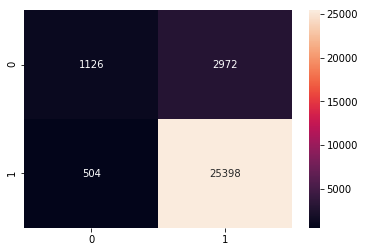

TPR for the model on test data is 0.98
FPR for the model on test data is 0.73
TNR for the model on test data is 0.27
FNR for the model on test data is 0.02



In [31]:
# Fitting the best model

lr = LogisticRegression(penalty='l2', C=1)
lr.fit(X_train_w2v, y_train_w2v)
y_pred_w2v = lr.predict(X_test_w2v)

# Generating the confusion matrix
cm_w2v = confusion_matrix(y_test_w2v , y_pred_w2v)
print("Confusion Matrix:")
sns.heatmap(cm_w2v, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_w2v.ravel()

tnr_w2v = tn/(tn+fp)
fpr_w2v = fp/(tn+fp)
fnr_w2v = fn/(fn+tp)
tpr_w2v = tp/(fn+tp)

print("TPR for the model on test data is {:.2f}".format(tpr_w2v))
print("FPR for the model on test data is {:.2f}".format(fpr_w2v))
print("TNR for the model on test data is {:.2f}".format(tnr_w2v))
print("FNR for the model on test data is {:.2f}\n".format(fnr_w2v))

In [32]:
# calculating accuracy, precision and recall 

accuracy_w2v = accuracy_score(y_test_w2v , y_pred_w2v)
precision_w2v = precision_score(y_test_w2v , y_pred_w2v)
recall_w2v = recall_score(y_test_w2v , y_pred_w2v)
f1_w2v = f1_score(y_test_w2v , y_pred_w2v)

print("Accuracy score for the model on test data is {:.2f}".format(accuracy_w2v))
print("Precision score for the model on test data is {:.2f}".format(precision_w2v))
print("Recall score for the model on test data is {:.2f}".format(recall_w2v))
print("F1 score for the model on test data is {:.2f}\n".format(f1_w2v))

Accuracy score for the model on test data is 0.88
Precision score for the model on test data is 0.90
Recall score for the model on test data is 0.98
F1 score for the model on test data is 0.94



### 4.2.4 Checking for sparsity with increasing value of  λ (decreasing C)

In [33]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(X_train_w2v, y_train_w2v)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=50
lambda=10.0 ; non-zeros=49
lambda=100.0 ; non-zeros=34
lambda=1000.0 ; non-zeros=9
lambda=10000.0 ; non-zeros=0


Again, we can't check for multicollinearity for this vectorization technique as we don't have any feature corresponding to a particular word.  What we can do is just to extract most important features in the form of list.

In [34]:
# Taking values for probabilities for Average-W2V

prob_score = lr.predict_log_proba(X_train_w2v)

neg_bow = prob_score[:,0].argsort()
pos_bow = prob_score[:,1].argsort()

# Taking words with Maximum Probabilities for negative and positive labels
neg_words = np.take(tfidf_sent_vectors, neg_bow[-10:])
pos_words = np.take(tfidf_sent_vectors, pos_bow[-10:])

print("Negative Words are:\n" , neg_words, end='\n\n')
print("Positive Words are:\n" , pos_words)

Negative Words are:
 [-0.16725518  0.47582129 -0.0032757   0.70867107  0.34610551  0.05484068
 -0.71122109  0.13882007 -1.10426409 -1.70038425]

Positive Words are:
 [-0.86806124 -0.03538375  0.03252355  1.52272252  0.19294682 -0.48993716
  0.28793287  0.72952546  0.43488519 -0.54336549]


# 5.0 Conclusion

Logistic regression was successfully applied on all the text-processing techniques.

In order to accomplish this task, 4 types of Text processing techniques were applied. First the optimal value of lambda was estimated using grid-search and then the model was fit using the value of optimal lambda.

Post successful fitting of the model, the polarity (labels) on the test dataset was estimated using the model and was checked against the true polarity. Based on this, Accuracy, Precision-Score, Recall Score and F1-Score were calculated.

The values of all the parameters are tabulated in the following table-



<html>
<head>

<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}
    
tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>
<body>

<h2>Table 5.1: Values of different parameters with Model</h2>

<table>
  <tr>
    <th>Model</th>
    <th>Cross-Validation Technique</th>
    <th>Regularization</th>
    <th>Best C</th>
    <th>Best λ=(1/C)</th>
    <th>F1 Score</th>
  </tr>
  <tr>
    <td>Bag-of-Words</td>
    <td>GridSearchCV</td>
    <td>L1</td>
    <td>0.01</td>
    <td>100</td>
    <td>0.95</td>
  </tr>
  <tr>
    <td>Bag-of-Words</td>
    <td>GridSearchCV</td>
    <td>L2</td>
    <td>0.01</td>
    <td>100</td>
    <td>0.95</td>
  </tr>
  <tr>
      <td>Bag-of-Words</td>
    <td>RandomSearchCV</td>
    <td>L1</td>
    <td>1</td>
    <td>1</td>
    <td>0.93</td>
   </tr>
  <tr>
      <td>Bag-of-Words</td>
    <td>RandomSearchCV</td>
    <td>L2</td>
    <td>0.1</td>
    <td>10</td>
    <td>0.94</td>
  </tr>
  <tr>
    <td>TF-IDF</td>
    <td>GridSearchCV</td>
    <td>L1</td>
    <td>100</td>
    <td>0.01</td>
    <td>0.95</td>
  </tr>
  <tr>
      <td>TF-IDF</td>
    <td>GridSearchCV</td>
    <td>L2</td>
    <td>0.01</td>
    <td>100</td>
    <td>0.95</td>
  </tr>
  <tr>
    <td>TF-IDF</td>
    <td>RandomSearchCV</td>
    <td>L1</td>
    <td>1</td>
    <td>1</td>
    <td>0.93</td>
   </tr>
  <tr>
      <td>TF-IDF</td>
    <td>RandomSearchCV</td>
    <td>L2</td>
    <td>100</td>
    <td>0.01</td>
    <td>0.94</td>
  </tr>
  <tr>
    <td>Average W2V</td>
    <td>GridSearchCV</td>
    <td>L1</td>
    <td>1</td>
    <td>1</td>
    <td>0.96</td>
  </tr>
  <tr>
      <td>Average W2V</td>
    <td>GridSearchCV</td>
    <td>L2</td>
    <td>1</td>
    <td>1</td>
    <td>0.96</td>
  </tr>
  <tr>
    <td>Average W2V</td>
    <td>RandomSearchCV</td>
    <td>L1</td>
    <td>1</td>
    <td>1</td>
    <td>0.96</td>
   </tr>
  <tr>
      <td>Average W2V</td>
    <td>RandomSearchCV</td>
    <td>L2</td>
    <td>10</td>
    <td>0.1</td>
    <td>0.96</td>
  </tr>
  <tr>
    <td>Weighted W2V</td>
    <td>GridSearchCV</td>
    <td>L1</td>
    <td>100</td>
    <td>0.01</td>
    <td>0.94</td>
  </tr>
  <tr>
      <td>Weighted W2V</td>
    <td>GridSearchCV</td>
    <td>L2</td>
    <td>1</td>
    <td>1</td>
    <td>0.94</td>
  </tr>
  <tr>
      <td>Weighted W2V</td>
      <td>RandomSearchCV</td>
    <td>L1</td>
    <td>10</td>
    <td>0.1</td>
    <td>0.94</td>
   </tr>
  <tr>
      <td>Weighted W2V</td>
      <td>RandomSearchCV</td>
    <td>L2</td>
    <td>10</td>
    <td>0.1</td>
    <td>0.94</td>
  </tr> 
</table>




<h2>Table 5.2: Test Metrics</h2>

<table>
  <tr>
    <th>Model</th>
    <th>λ=(1/C)</th>
    <th>Penalty</th>
    <th>Test Accuracy</th>
    <th>Precision Score</th>
    <th>Recall Score</th>
    <th>F1 Score</th>
  </tr>
  <tr>
    <td>Bag-of-Words</td>
    <td>100</td>
    <td>L2</td>
    <td>91 %</td>
    <td>0.94</td>
    <td>0.95</td>
    <td>0.96</td>
  </tr>
  <tr>
    <td>TF-IDF</td>
    <td>0.1</td>
    <td>L2</td>
    <td>92 %</td>
    <td>0.94</td>
    <td>0.97</td>
    <td>0.96</td>
  </tr>
  <tr>
    <td>Average W2V</td>
    <td>1</td>
    <td>L1</td>
    <td>89 %</td>
    <td>0.91</td>
    <td>0.98</td>
    <td>0.94</td>
  </tr>
  <tr>
    <td>Weighted W2V</td>
    <td>1</td>
    <td>L2</td>
    <td>88 %</td>
    <td>0.90</td>
    <td>0.98</td>
    <td>0.94</td>
  </tr>
</table>

</body>
</html>

So, from the table data we can conclude that Grid-Search and Random-Search result in almost similar outcomes. 

Also, the sparsity increases (non-zeros decrease) with increasing values of λ.